In [1]:
# univariate multi-step lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras import Model, layers
from keras.models import load_model, model_from_json


Using TensorFlow backend.


In [2]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

In [3]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [4]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))


In [5]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)


In [6]:
# train the model
def build_and_train_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


In [7]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [18]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_and_train_model(train, n_input)
    model.save('models/RNN_UniVariate_BasicLSTM_Model_21dayinput.h5')

    # architecture to JSON, weights to HDF5
    model.save_weights('models/RNN_UniVariate_BasicLSTM_Model_Weights_21dayinput.h5')
    with open('models/RNN_UniVariate_BasicLSTM_Model_architecture_21dayinput.json', 'w') as f:
            f.write(model.to_json())
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [19]:
def load_pretrained_model(train, test, n_input):
    # architecture and weights from HDF5
    model = load_model('models/RNN_UniVariate_BasicLSTM_Model_21dayinput.h5')

    # architecture from JSON, weights from HDF5
    with open('models/RNN_UniVariate_BasicLSTM_Model_architecture_21dayinput.json') as f:
        model = model_from_json(f.read())
    model.load_weights('models/RNN_UniVariate_BasicLSTM_Model_Weights_21dayinput.h5')
    
    
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores
    

Epoch 1/70
1099/1099 [==============================] - 2s 2ms/step - loss: 731061.9797
Epoch 2/70
1099/1099 [==============================] - 1s 1ms/step - loss: 272933.9677
Epoch 3/70
1099/1099 [==============================] - 3s 3ms/step - loss: 271412.9152
Epoch 4/70
1099/1099 [==============================] - 1s 1ms/step - loss: 271473.7073
Epoch 5/70
1099/1099 [==============================] - 1s 1ms/step - loss: 271828.0568
Epoch 6/70
1099/1099 [==============================] - 3s 3ms/step - loss: 266028.3056
Epoch 7/70
1099/1099 [==============================] - 1s 1ms/step - loss: 262034.7108
Epoch 8/70
1099/1099 [==============================] - 1s 1ms/step - loss: 262734.6129
Epoch 9/70
1099/1099 [==============================] - 3s 3ms/step - loss: 262792.5874
Epoch 10/70
1099/1099 [==============================] - 1s 1ms/step - loss: 261021.0424
Epoch 11/70
1099/1099 [==============================] - 1s 1ms/step - loss: 257741.0457
Epoch 12/70
1099/1099 [=======

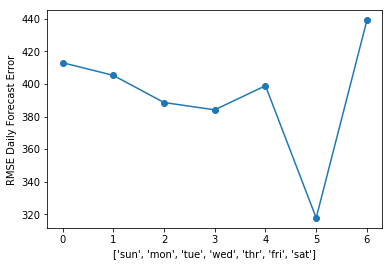

In [10]:
# load the new file
dataset = read_csv('smart meter dataset\household_power_consumption\household_power_consumption_Naive_Forecast_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

lstm: [393.973] 413.1, 405.3, 388.6, 384.1, 398.9, 317.7, 439.2


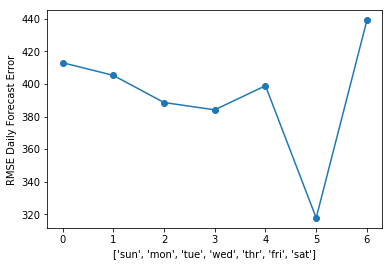

In [12]:
# evaluate model and get scores
n_input = 7
score, scores = load_pretrained_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

Epoch 1/70
1092/1092 [==============================] - 4s 4ms/step - loss: 828075.8951
Epoch 2/70
1092/1092 [==============================] - 4s 3ms/step - loss: 339533.9834
Epoch 3/70
1092/1092 [==============================] - 5s 4ms/step - loss: 274616.7342: 0s - loss: 267127.24 - ETA: 0s - ETA: 1s
Epoch 4/70
1092/1092 [==============================] - 2s 2ms/step - loss: 266921.9565
Epoch 5/70
1092/1092 [==============================] - 5s 4ms/step - loss: 277362.2188: 1s -
Epoch 6/70
1092/1092 [==============================] - 5s 4ms/step - loss: 277348.6260
Epoch 7/70
1092/1092 [==============================] - 3s 2ms/step - loss: 270258.8684
Epoch 8/70
1092/1092 [==============================] - 4s 4ms/step - loss: 265805.3447
Epoch 9/70
1092/1092 [==============================] - 5s 4ms/step - loss: 261772.3637
Epoch 10/70
1092/1092 [==============================] - 2s 2ms/step - loss: 260048.5974
Epoch 11/70
1092/1092 [==============================] - 5s 4ms/step - 

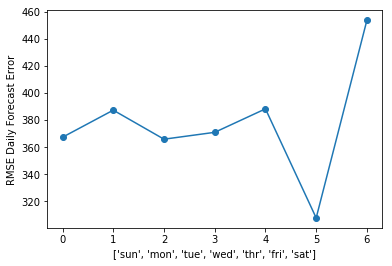

In [15]:
# load pretrained model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

lstm: [379.463] 367.4, 387.3, 365.9, 371.0, 388.3, 307.9, 453.7


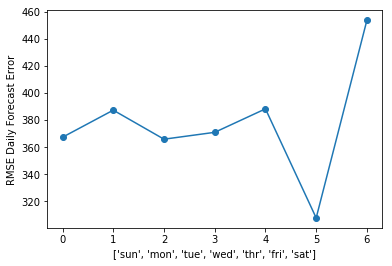

In [16]:
# load pretrained model and get scores
n_input = 14
score, scores = load_pretrained_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

Epoch 1/70
1085/1085 [==============================] - 8s 7ms/step - loss: 531933.3113
Epoch 2/70
1085/1085 [==============================] - 6s 5ms/step - loss: 436722.8041
Epoch 3/70
1085/1085 [==============================] - 6s 5ms/step - loss: 680381.7732
Epoch 4/70
1085/1085 [==============================] - 5s 5ms/step - loss: 288984.8373
Epoch 5/70
1085/1085 [==============================] - 5s 5ms/step - loss: 279357.4086: 1s - los
Epoch 6/70
1085/1085 [==============================] - 5s 5ms/step - loss: 270341.2881
Epoch 7/70
1085/1085 [==============================] - 3s 3ms/step - loss: 270270.5899
Epoch 8/70
1085/1085 [==============================] - 5s 4ms/step - loss: 269079.4808
Epoch 9/70
1085/1085 [==============================] - 5s 5ms/step - loss: 269326.3998
Epoch 10/70
1085/1085 [==============================] - 5s 5ms/step - loss: 263605.3138: 0s - loss: 26201
Epoch 11/70
1085/1085 [==============================] - 5s 5ms/step - loss: 266315.3800
Ep

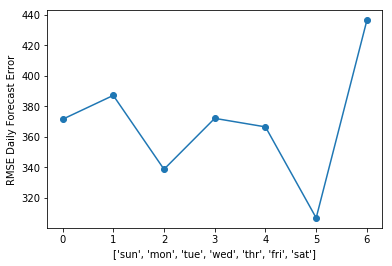

In [20]:
# load pretrained model and get scores
n_input = 21
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()

lstm: [370.380] 371.5, 387.2, 338.8, 372.2, 366.6, 307.0, 436.3


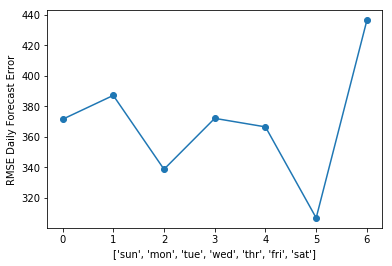

In [21]:
# load pretrained model and get scores
n_input = 21
score, scores = load_pretrained_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.xlabel(days_label)
pyplot.ylabel("RMSE Daily Forecast Error")
pyplot.show()